<a href="https://colab.research.google.com/github/UlyShel/basics_of_deep_learning/blob/main/HW3_Shelegova_Ulyana_OGO6_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

### А ещё есть консультация 2023 года :)

https://www.youtube.com/watch?v=oCwEmKW3bYg

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом. На Windows, скорее всего, вас ждет немало проблем :(

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

Отдельная благодарность А. Абрамову за написание assert для проверки функций и В. Гилязову за поясняющую картинку.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [ ]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip

!unzip -q data.zip

--2024-11-24 20:57:28--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2024-11-24 20:57:29--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.06s   

2024-11-24 20:57:29 (295 MB/s) - ‘data.zip’ saved [17592727/17592727]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):

        # https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        # https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python
        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(member.find("bndbox/ymin").text)
        xmin = int(member.find("bndbox/xmin").text)
        ymax = int(member.find("bndbox/ymax").text)
        xmax = int(member.find("bndbox/xmax").text)

        label = class_dict[member.find("name").text]

        res =  [xmin, ymin, xmax, ymax, label]

        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):

        fname = self.filenames[idx]
        image = Image.open(fname).convert("RGB")
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=np.array(image), bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [ ]:
class_labels = {'snitch': 0, 'quaffle': 1, 'bludger': 2}
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        image = images[i].permute(1, 2, 0).numpy()
        image = image * std + mean
        image = image.clip(0, 1)
        ax.imshow(image)

        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, cls = bbox
            # https://stackoverflow.com/questions/67580645/how-to-visualize-a-trained-model-with-bounding-boxes-for-object-detection
            rect = plt.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)

            ax.text(xmin, ymin - 10, f'{[k for k, v in class_labels.items() if v == int(cls)][0]}', color='red', fontsize=8, verticalalignment='baseline')

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://i.imgur.com/V5TUT26.png)

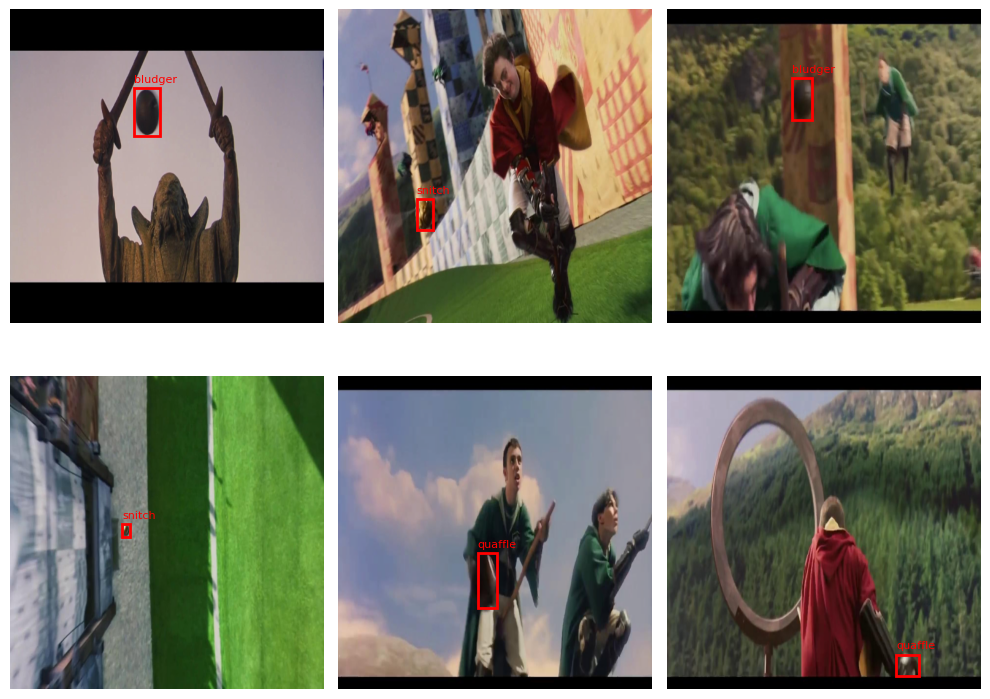

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и вернуть тензор размера Bx6x16x16. Первая размерность - это количество примеров в батче. Вторая -- "каналы", суть которых написана чуть ниже. Далее идут две пространственные размерности, это сетка 16 на 16. Зафиксируем порядок координат как (y, x) для этой сетки 16 на 16. Это значит, что в target идут ```cy_idx, cx_idx``` в таком порядке, см. код.

В шести "каналах" у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "гиперпиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

### Пояснительная картинка.

Она обладает некоторым уровнем абстракции, чёрных например должно быть 512, а зелёная должна захватывать 32 маленькие черные. Но может будет понятнее :)

![image](https://i.imgur.com/13YVxAd.jpeg)

In [ ]:
# мы условно проходим через все примеры тренировочной выборки и собираем информацию о том, где находится bbox, его размер и тд, чтобы потом эти знания применять на тесте
# функция собирает данные из нашего набора данных в батчи для передачи в нейронную сеть

def collate_fn(batch, downsample=32): # downplay - на сколько уменьшить изображение для обработки
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs) #тензор для изображений
    b, _, h, w = imgs.shape # количество изображений, каналов, высота и ширина

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample) # новый тензор - тут уже 6 каналов, как и написано в задании

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):

        xmin, ymin, xmax, ymax, classes = map(
              torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
            )


        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  w // (w // downsample) # размер гиперпикселя
        y_cell =  h // (h // downsample)

        # ширина и высота бибокса могут превышать размеры гиперпикселя
        # поэтому их мы нормируем на полноценные 512
        w_box =  (xmax - xmin) / w
        h_box =  (ymax - ymin) / h

        # Посчитайте координаты центра и сдвиги
        cx = (xmax + xmin) / 2 # центр bbox
        cy =  (ymax + ymin) / 2
        cx_idx =  (cx // downsample).long()  #  индекс гиперпикселя, в который попадает центр bbox
        cy_idx =  (cy // downsample).long()

        cx_box = (cx - (cx_idx * x_cell)) / x_cell # сдивиги относительно cx_idx
        # объясняю логику: сначала я нахожу координаты начала ячейки (cx_idx - гиперпиксель, в который попадает центр bbox, а умножаю его на размер клетки для того, чтобы понять, какой первый пиксель у этой клетки из исходного масштабирования)
        # cx - центр bbox. вычитая из него координату начала гиперписеля я понимаю, насколько смешен центр ббокса внутри
        # делю на x_cell, чтобы конвертировать расстояние в долю ячейки, то есть получаемся float от 0 до 1, чтобы понять, насколько далеко от левого края находится центр
        cy_box =  (cy - (cy_idx * y_cell)) / y_cell

        # cy_idx, потом cx_idx
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [ ]:
def test_collate_fn() -> None:
    target1 = [ 100, 200, 200, 300, 2 ] # xmin, ymin, xmax, ymax, class
    target2_1 = [ 0, 250, 200, 300, 0 ] # xmin, ymin, xmax, ymax, class
    target2_2 = [ 0, 100, 100, 300, 1 ] # xmin, ymin, xmax, ymax, class

    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target1 ] },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target2_1, target2_2 ] }
    ])

    # Проверяем размерности
    assert result['image'].shape == (2, 3, 512, 512)
    assert result['target'].shape == (2, 6, 16, 16)

    # Проверяем значения клеточек, в которые попали ббоксы
    assert np.allclose(result['target'][0, :, 7, 4], torch.tensor([ 22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2 ]))
    assert np.allclose(result['target'][1, :, 8, 3], torch.tensor([ 4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0 ]))
    assert np.allclose(result['target'][1, :, 6, 1], torch.tensor([ 18 / 32, 8 / 32, 100 / 512, 200 / 512, 1, 1 ]))

    # Проверяем, что все остальные клеточки содержат нули
    result['target'][0, :, 7, 4] = result['target'][1, :, 8, 3] = result['target'][1, :, 6, 1] = torch.zeros(6)
    assert np.allclose(result['target'], 0)

test_collate_fn()

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

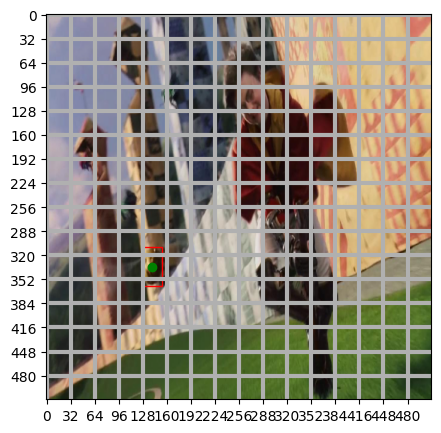

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
  xmin, ymin, xmax, ymax = bbox[:4]
  w = xmax - xmin
  h = ymax - ymin

  ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx6x16x16. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):

    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    preds = []

    for i in range(b):
        bboxes = []
        for y_idx in range(h):  # для каждой строки
            for x_idx in range(w):  # столбца
                if c == 6:
                    cx_box, cy_box, w_box, h_box, confidence, cls = pred[i, :, y_idx, x_idx]

                    cx_box_norm = (cx_box * upsample) + (x_idx * upsample) # если cx_box и cy_box - смещенные координаты центра. Здесь мы увеличиваем до стандарт размера ячейки + смещаем на количество пикселей, где находится ячейка
                    cy_box_norm = (cy_box * upsample) + (y_idx * upsample)

                    x_min = int(cx_box_norm - (w_box * img_w) // 2)
                    y_min = int(cy_box_norm - (h_box * img_h) // 2) # из координаты центра вычитаю половины высоты (как раз получается нижняя граница) - дальше такая же логика
                    x_max = int(cx_box_norm + (w_box * img_w) // 2)
                    y_max = int(cy_box_norm + (h_box * img_h) // 2)

                    if confidence > threshold:
                        bboxes.append([x_min, y_min, x_max, y_max, int(cls)])
                else:
                    cx_box = pred[i, 0, y_idx, x_idx]
                    cy_box = pred[i, 1, y_idx, x_idx]
                    w_box = pred[i, 2, y_idx, x_idx]
                    h_box = pred[i, 3, y_idx, x_idx]
                    confidence = pred[i, 4, y_idx, x_idx]
                    cls_max = pred[i, 5:, y_idx, x_idx].argmax()
                    cls = cls_max.item()

                    if confidence > threshold:

                        cx_box_norm = (cx_box * upsample) + (x_idx * upsample)
                        cy_box_norm = (cy_box * upsample) + (y_idx * upsample)

                        xmin = int(cx_box_norm - (w_box * img_w) // 2)
                        ymin = int(cy_box_norm - (h_box * img_h) // 2)
                        xmax = int(cx_box_norm + (w_box * img_w) // 2)
                        ymax = int(cy_box_norm + (h_box * img_h) // 2)

                        bboxes.append([xmin, ymin, xmax, ymax, cls])

        preds.append(bboxes)

    return preds

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [ ]:
def test_decode_predictions() -> None:
    # Применяем collate_fn к некоторым данным
    target1 = [ [ 100, 200, 200, 300, 2 ] ]
    target2 = [ [ 0, 250, 200, 300, 0 ], [ 0, 100, 100, 300, 1 ] ]
    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target1 },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target2 }
    ])

    target = result['target']
    assert target.shape == (2, 6, 16, 16)
    # В таком виде target соответствует поиску одного класса - 6-ой канал.
    # Добавим еще 2 канала, чтобы проверить работу функции для нескольких классов
    target = torch.cat([ target, torch.zeros(2, 2, 16, 16) ], dim = 1) # Добавляем два канала
    assert target.shape == (2, 8, 16, 16) # Теперь их стало 8

    target[0, 5:, 7, 4] = torch.tensor([ 0.5, 0.6, 0.9 ]) # Это должен быть класс 2
    target[1, 5:, 8, 3] = torch.tensor([ 0.9, 0.6, 0.5 ]) # Это должен быть класс 0
    target[1, 5:, 6, 1] = torch.tensor([ 0.6, 0.9, 0.5 ]) # Это должен быть класс 1

    # Считаем результат
    actual = decode_prediction(target)
    print('Actual:  ', actual)

    # Порядок ббоксов для target2 может меняться в зависимости от вашей реализации и это не ошибка.
    # Скорее всего, он будет такой. Но если ассерт не проходит, попробуйте поменять их местами.
    expected = [ target1, [ target2[1], target2[0] ] ]
    # expected = [ target1, [ target2[0], target2[1] ] ] # <-- такой ответ тоже правильный.
    print('Expected:', expected)

    # Сравниваем
    assert actual == expected

test_decode_predictions()

Actual:   [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]
Expected: [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]


## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [ ]:
from torchvision.models import resnet50

In [ ]:
some_model = resnet50(pretrained=True)
some_model  # вспомнила, как на 4 семинаре смотрели названия слоев

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
C = len(train_ds.class_dict)

class Detector(nn.Module):
    def __init__(self, cls):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

        self.relu = torch.nn.ReLU()

        self.relu = nn.ReLU()

        self.model_parts = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
          ) # после этой части размер изображения уже 16 на 16, я проверила


        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2048, out_channels=512, padding = 1, kernel_size=3),
            self.relu,
            torch.nn.BatchNorm2d(512),
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=512, out_channels=128, padding = 1, kernel_size=3),
            self.relu,
            torch.nn.BatchNorm2d(128),
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=32, padding = 1, kernel_size=3),
            self.relu,
            torch.nn.BatchNorm2d(32),
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=5+cls, padding = 1, kernel_size=3),
            self.relu,
            torch.nn.BatchNorm2d(5+cls),
        )

        self.sigmoid = nn.Sigmoid()


    def forward(self, img):

        x = self.model_parts(img)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.sigmoid(x)

        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch) ДОЛЖНЫ ПРИМЕНЯТЬ И ТАРГЕТУ И К ПРЕДИКШНУ - как сделать маску? таргет с нужными индексами больше нуля
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект (сначала посмотреть по x координате, потом по y)
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект (разбить отельно на ширину и на высоту)
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу (мы не можем просто применить masked_select. возьмем три штуки классов

    for i in range ...
    идем по каналам
    и в маскд селект записываем
arr-append (masked_select)
torch stack(arr dim=..)
-> вектора длины 3, а в таргете одно число -> маскд селект от 5 канала в таргете ->  и мы считаем просто кроссэнтропию target 5 • masked_select

    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)

* Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [ ]:
import torch.nn as nn

def special_loss(pred, target, C=C):

  pred_boxes = pred[:, :4] #  координаты центра (cx, cy), ширина и высота
  pred_confidence = pred[:, 4] # уверенность

  target_boxes = target[:, :4]
  target_confidence = target[:, 4]

  # https://pytorch.org/docs/stable/generated/torch.masked_select.html
  mask = target_confidence > 0  # уверенность в наличии объекта
  no_mask = ~mask # маска, где нет объекта - нужно для confidence loss

  local_pred = pred_boxes[:, :2] # координаты центра
  local_target = target_boxes[:, :2]
  localization_loss = nn.functional.mse_loss(local_pred.masked_select(mask.unsqueeze(1)), local_target.masked_select(mask.unsqueeze(1)),
                                             reduction="sum")

  box_pred = pred[:, 2:4].sqrt()  # ширина и высота
  box_target = target[:, 2:4].sqrt()
  box_loss = nn.functional.mse_loss(box_pred.masked_select(mask.unsqueeze(1)), box_target.masked_select(mask.unsqueeze(1)),
        reduction="sum")

  pred_classes = pred[:, 5:] # классы
  target_classes = target[:, 5].long()

  classification_loss = nn.functional.cross_entropy(pred_classes.permute(0, 2, 3, 1)[mask], target_classes[mask],
        reduction="sum")

  # https://discuss.pytorch.org/t/use-class-weight-with-binary-cross-entropy-loss/125265/2
  weight_detected = 1.0
  weight_undetected = 0.1 # уменьшила в 10 раз уже во время обучения для того, чтобы уменьшитъ ошибку
  # она была 222 на 1 эпохе, по итогу стала 26
  # это полезно как минимум по тому, что модели становится все невыгоднее ставить нули

  # для ячеек с объектами
  confidence1 = nn.functional.binary_cross_entropy(pred_confidence.masked_select(mask), target_confidence.masked_select(mask),
        reduction="sum")

  # ячейки без объектов считаю отдельно
  confidence2  = nn.functional.binary_cross_entropy(pred_confidence.masked_select(no_mask), target_confidence.masked_select(no_mask),
        reduction="sum")

  confidence_loss = confidence1 * weight_detected  + confidence2 * weight_undetected

  return localization_loss + box_loss + classification_loss + confidence_loss

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
torch.manual_seed(21)
EPOCHS = 20
model = Detector(cls=C).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    torch.cuda.empty_cache()
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
      torch.cuda.empty_cache()
      x_train, y_train = batch['image'].to(device), batch['target'].to(device)
      y_train_pred = model(x_train).to(device)

      train_loss = special_loss(y_train_pred, y_train)
      model.zero_grad()
      train_loss.backward()
      opt.step()
      epoch_losses.append(train_loss.item())
      torch.cuda.empty_cache()

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 247MB/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 done; Train loss 202.611;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 183.068;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 176.981;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 170.277;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 165.633;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 162.092;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 157.875;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 154.713;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 150.881;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 148.858;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 147.088;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 142.211;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 139.985;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 137.181;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 134.602;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 131.028;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 128.973;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 126.993;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 126.430;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 123.307;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu

model.eval()
pred = []
images = []

for batch in tqdm(test_loader):
  x_test = batch['image'].to(device)
  y_test = batch['target'].to(device).float()
  y_test_pred = model(x_test).to(device)

  images.extend(x_test)
  pred.extend(y_test_pred.cpu())

  test_loss = special_loss(y_test_pred, y_test)
  test_loss += test_loss.cpu().item()

images = torch.stack(images).cpu()

  0%|          | 0/5 [00:00<?, ?it/s]

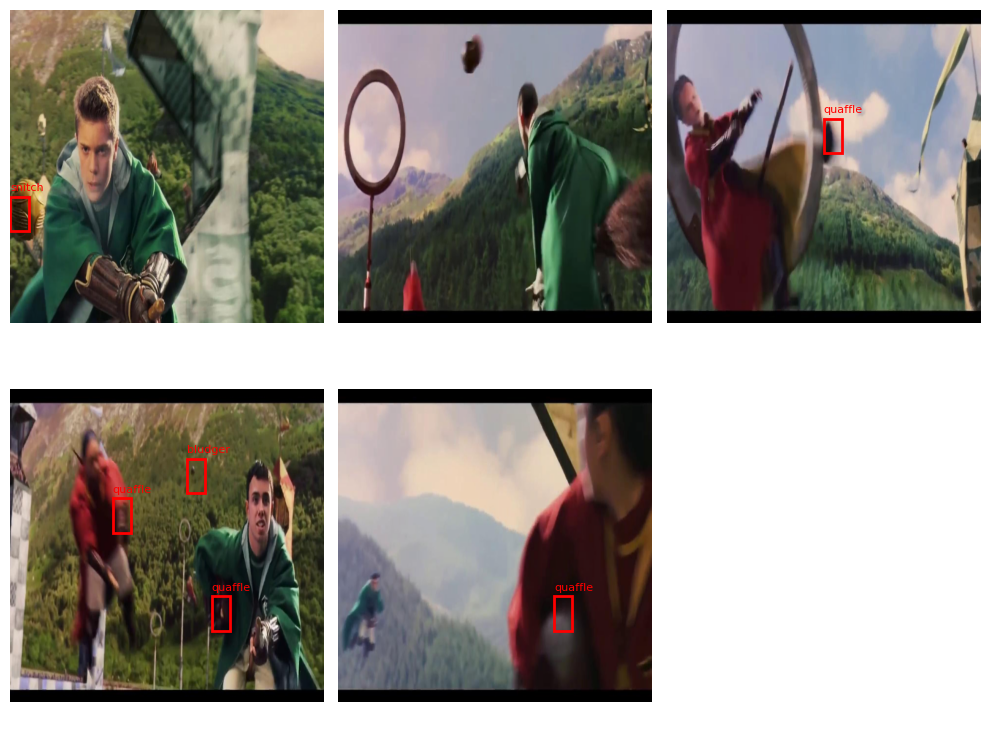

In [ ]:
decoded_preds = decode_prediction(torch.stack(pred))
visualize(images[:5], decoded_preds[:5])

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

А У МЕНЯ ХОРОШИЙ РЕЗ С ПРЕДСКАЗАНИЯМИ!!!! БЛАДЖЕРЫ ДАЖЕ ОТ КВОФЛОВ ОТЛИЧАЮТСЯ
(но с ббоксами беда, конечно, сильно маленькие)

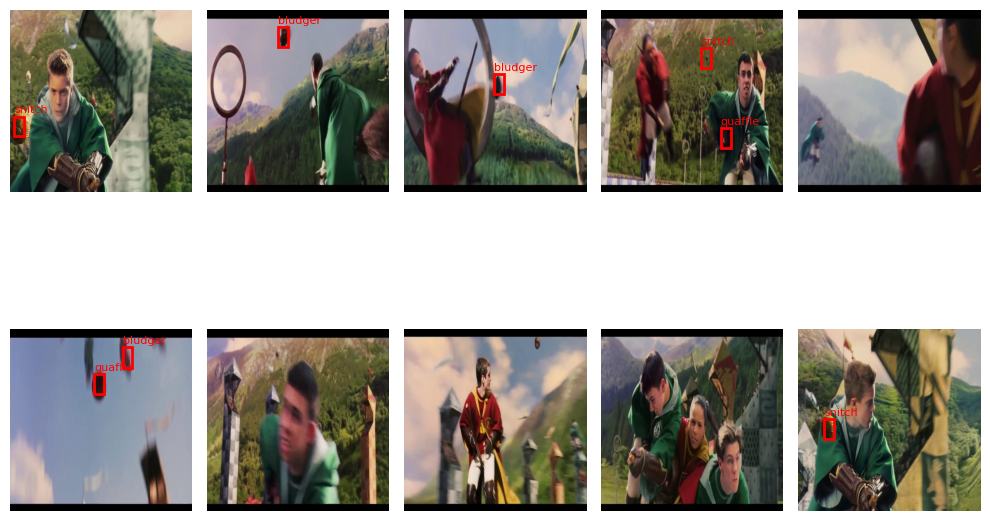

In [ ]:
decoded_preds = decode_prediction(torch.stack(pred))
visualize(images[:10], decoded_preds[:10])

ну хотя вот здесь действительно видно, что и в плане предсказаний не на всех картинках находит (8 картинка), но в целом я своим рукописным кодом довольна!!!

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO 11 от ultralytics.

In [ ]:
!pip install ultralytics

In [ ]:
!pip install ultralytics==8.3.34

## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO 11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

Использовать сторонние инструменты нельзя, нужно переложить своими руками.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    lines = []
    for bbox in bboxes:

      # https://roboflow.com/formats/yolov8-pytorch-txt - тут узнала про формат
      xmin, ymin, xmax, ymax, class_id = bbox
      x_center = (xmin + xmax) / 2 / w_im
      y_center = (ymin + ymax) / 2 / h_im
      width = (xmax - xmin) / w_im # форматирую столбцы
      height = (ymax - ymin) / h_im # форматирую строки
      line = f"{int(class_id)} {x_center} {y_center} {width} {height}"
      lines.append(line)

    return lines

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc =  len(train_ds.class_dict)
names = ['snitch', 'quaffle', 'bludger']

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO 11 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель можно взять обученную.

Подсказка: подумайте зачем вам data.yaml и что такое yolo11n.yaml (не стесняйтесь гуглить)

Если у вас лосс NaN или Windows, то есть несколько полезных ссылок (покрывают не все существующие проблемы, но может поможет вам):

https://github.com/ultralytics/ultralytics/issues/1149

https://github.com/ultralytics/yolov5/issues/6907

https://stackoverflow.com/questions/75178762/i-got-nan-for-all-losses-while-training-yolov8-model

In [ ]:
import ultralytics

# https://docs.ultralytics.com/modes/train/#usage-examples
torch.cuda.empty_cache()
model = ultralytics.YOLO('yolo11n.yaml')
model.train(data='data.yaml', epochs=100, name='train_weights')

New https://pypi.org/project/ultralytics/8.3.36 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.yaml, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train_weights8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False

train: Scanning /content/train/labels... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<00:00, 1314.53it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 29 images, 0 backgrounds, 1 corrupt: 100%|██████████| 29/29 [00:00<00:00, 804.42it/s]

val: WARNING ⚠️ /content/valid/images/275.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4053]
val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train_weights8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train_weights8
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.97G      4.921       10.4      4.237         29        640: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         28         29          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.93G      4.395      9.588      4.129         36        640: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         28         29          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.92G      3.986       8.17      3.834         35        640: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         28         29          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.92G      3.799      7.209      3.466         28        640: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         28         29          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.92G      3.876      7.164      3.275         20        640: 100%|██████████| 16/16 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         28         29          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.92G      3.333      6.236      3.009         38        640: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         28         29          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.92G      3.198      6.201      2.777         36        640: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         28         29          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.92G      3.113      5.438      2.684         30        640: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         28         29   0.000348     0.0256   0.000191   5.72e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.94G      2.835      5.051      2.573         34        640: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all         28         29   0.000863      0.162     0.0681     0.0208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.94G      2.667      4.682      2.418         26        640: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all         28         29      0.915     0.0756     0.0665     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.92G       2.73      4.427      2.356         21        640: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         28         29      0.813     0.0256     0.0157     0.0064



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.92G      2.598      4.267      2.191         25        640: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         28         29       0.74     0.0513      0.028      0.006



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.92G      2.623      4.115      2.194         29        640: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         28         29      0.965     0.0769     0.0832     0.0328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.92G      2.482      3.896      2.137         27        640: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         28         29      0.521       0.11     0.0816     0.0526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.92G      2.473      3.858      2.127         25        640: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         28         29      0.208      0.136      0.102      0.048



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.92G      2.309      3.383      2.055         29        640: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         28         29       0.22      0.166     0.0863     0.0327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.92G      2.387      3.255      2.013         38        640: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         28         29       0.16      0.136      0.103     0.0348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.92G      2.224      3.114      1.927         34        640: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         28         29      0.569      0.106     0.0898     0.0486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.92G      2.191      2.995      1.844         36        640: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         28         29      0.298      0.144      0.139     0.0634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.92G      2.209      2.917      1.853         33        640: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         28         29      0.234      0.144      0.123       0.05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.92G        2.2      2.805      1.869         25        640: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all         28         29      0.216      0.144      0.125     0.0589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.92G        2.2      2.794      1.875         26        640: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         28         29      0.286      0.189      0.143     0.0491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.92G      2.144      2.541      1.823         30        640: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all         28         29      0.334      0.141      0.127     0.0637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.92G      2.127      2.679       1.78         31        640: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         28         29      0.238      0.199      0.145     0.0667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.92G      2.106      2.563      1.745         32        640: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         28         29      0.281      0.193      0.145       0.07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.92G      2.058      2.488      1.677         24        640: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all         28         29      0.114      0.217      0.117     0.0521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.92G       2.08        2.4      1.766         25        640: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         28         29       0.21      0.202      0.142     0.0641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.92G      2.041      2.278      1.701         26        640: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all         28         29      0.328       0.11      0.153     0.0855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.94G      2.013      2.335       1.72         39        640: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all         28         29       0.29      0.221      0.187     0.0754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.92G      1.972       2.27      1.676         26        640: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all         28         29      0.284      0.118      0.122     0.0609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.94G      1.885      2.144      1.639         24        640: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         28         29       0.24      0.312      0.163     0.0694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.92G      1.897      2.127      1.657         37        640: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         28         29      0.159      0.273      0.154      0.081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.92G       1.82      2.044      1.578         25        640: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         28         29      0.235      0.268      0.194     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.92G      1.808      2.038      1.576         32        640: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         28         29      0.327      0.166      0.152     0.0708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.94G      1.878      2.026      1.574         36        640: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         28         29      0.331      0.273      0.183     0.0826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.92G      1.839      1.986      1.593         27        640: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all         28         29      0.292      0.332      0.209     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.92G       1.82      2.002      1.593         37        640: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         28         29       0.25      0.332      0.187     0.0708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.92G      1.826      1.991      1.601         30        640: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all         28         29      0.199      0.314      0.159     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.92G      1.729      1.918      1.516         28        640: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         28         29      0.269      0.187      0.198     0.0986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.92G      1.749      1.877      1.491         19        640: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         28         29      0.317      0.317      0.208      0.098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.92G      1.725      1.839      1.513         30        640: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         28         29      0.327      0.331       0.22     0.0863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.92G      1.751      1.779      1.521         33        640: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         28         29      0.246      0.306      0.187     0.0845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.92G      1.671      1.726      1.498         25        640: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all         28         29      0.315      0.255      0.187     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.92G      1.659       1.73      1.437         22        640: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all         28         29      0.292      0.304      0.205     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.94G      1.677      1.732      1.458         36        640: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all         28         29      0.371      0.306      0.215     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.92G       1.66      1.691      1.494         24        640: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         28         29      0.299      0.332      0.234      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.92G      1.637       1.59      1.429         47        640: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         28         29       0.37      0.265      0.181     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.92G      1.643       1.64      1.449         23        640: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all         28         29      0.392       0.17      0.162     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.92G      1.646      1.705      1.418         26        640: 100%|██████████| 16/16 [00:02<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         28         29      0.375      0.298      0.225     0.0981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.92G      1.601      1.585      1.413         29        640: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all         28         29      0.348       0.26      0.196      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.92G      1.611      1.618      1.437         27        640: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all         28         29      0.395      0.328       0.23      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.92G      1.583      1.625      1.415         26        640: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         28         29      0.324      0.323      0.212       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.92G      1.642       1.61      1.459         31        640: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         28         29      0.354      0.267      0.219      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.94G      1.528      1.516      1.357         28        640: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all         28         29      0.354      0.375      0.246       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.92G      1.587      1.529      1.434         33        640: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         28         29      0.278      0.353       0.21      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.92G      1.565      1.511       1.41         31        640: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         28         29      0.333       0.29      0.228      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.92G      1.566      1.433      1.398         28        640: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         28         29      0.428       0.28      0.242      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.92G      1.517      1.412      1.379         32        640: 100%|██████████| 16/16 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         28         29      0.294      0.407      0.228       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.92G      1.543      1.452      1.333         27        640: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         28         29      0.417      0.367      0.266      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.92G       1.62      1.484      1.388         26        640: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         28         29      0.358      0.405      0.275       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.92G      1.555      1.421      1.376         28        640: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         28         29      0.299      0.438      0.282      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.92G      1.581      1.533      1.435         30        640: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         28         29      0.294      0.418      0.258      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.94G      1.554      1.445      1.388         28        640: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         28         29      0.324      0.324      0.279      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.92G      1.509      1.361      1.295         39        640: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         28         29      0.367      0.273      0.285      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.92G      1.488      1.377      1.319         29        640: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         28         29      0.393      0.378      0.294      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.94G      1.494      1.372       1.35         28        640: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         28         29      0.311      0.324      0.268      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.92G      1.413      1.276      1.292         32        640: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         28         29      0.288      0.387       0.26      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.92G      1.433      1.246      1.302         25        640: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         28         29      0.385      0.415      0.291      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.92G      1.403       1.25       1.28         34        640: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

                   all         28         29       0.41      0.419      0.313       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.92G      1.485      1.313       1.32         27        640: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all         28         29      0.275      0.379      0.234      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.92G       1.51       1.37      1.334         29        640: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         28         29      0.446      0.301      0.268      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.94G      1.379      1.257      1.273         26        640: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         28         29      0.388      0.353      0.313      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.92G      1.434       1.28      1.277         23        640: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         28         29      0.307      0.354      0.285      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.92G      1.406      1.315      1.311         25        640: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         28         29      0.385      0.387      0.309      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.92G      1.443       1.27      1.315         27        640: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         28         29      0.486      0.387      0.345      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.92G      1.415      1.242      1.301         29        640: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         28         29      0.513      0.415      0.337      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.94G      1.387      1.216      1.259         29        640: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all         28         29      0.329      0.494      0.275      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.92G      1.413      1.221      1.302         34        640: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         28         29      0.395      0.412      0.326       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.92G      1.382      1.201      1.282         34        640: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         28         29      0.352      0.442      0.306      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.92G      1.299      1.138       1.24         36        640: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         28         29      0.448      0.397      0.348      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.92G      1.427      1.215      1.317         34        640: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all         28         29       0.35      0.483      0.324       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.92G      1.377      1.202      1.292         36        640: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         28         29      0.504      0.413      0.325      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.92G      1.375      1.164      1.253         22        640: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         28         29      0.519      0.413      0.382      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.92G      1.317      1.098      1.246         29        640: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all         28         29      0.448      0.391      0.348      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.92G      1.354      1.167      1.249         27        640: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         28         29      0.508      0.371      0.318      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.92G      1.331      1.147      1.237         30        640: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         28         29      0.493      0.383      0.352       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.94G      1.349      1.181      1.245         29        640: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all         28         29       0.53      0.387      0.332       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.92G      1.331      1.178      1.283         19        640: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         28         29       0.44      0.404      0.329      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.92G      1.303      1.094      1.274         27        640: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         28         29      0.464      0.386      0.299      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.92G      1.324      1.111      1.242         27        640: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         28         29      0.434      0.405      0.335      0.184


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.93G      1.332      1.358      1.242         14        640: 100%|██████████| 16/16 [00:03<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         28         29       0.52      0.354      0.325      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.92G      1.339      1.226      1.259         14        640: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         28         29       0.51      0.354      0.326      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.93G      1.351      1.213      1.293         18        640: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all         28         29      0.443      0.372      0.303      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.93G      1.273      1.182      1.248         14        640: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         28         29      0.341      0.423      0.264      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.93G      1.252      1.121      1.221         15        640: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         28         29      0.448      0.328      0.272      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.93G       1.28      1.107      1.227         15        640: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         28         29      0.397      0.379       0.27      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.93G      1.266      1.156      1.221         18        640: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

                   all         28         29      0.489       0.37      0.294      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.92G      1.234      1.156      1.222         15        640: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all         28         29      0.484      0.372      0.295      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.92G      1.214      1.091      1.198         14        640: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         28         29      0.417      0.374      0.295      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.92G      1.233      1.131       1.22         14        640: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         28         29      0.414      0.381      0.301      0.172



100 epochs completed in 0.093 hours.
Optimizer stripped from runs/detect/train_weights8/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train_weights8/weights/best.pt, 5.5MB

Validating runs/detect/train_weights8/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


                   all         28         29      0.517      0.413      0.382      0.202
                snitch         10         10      0.239        0.2     0.0586     0.0363
               quaffle         13         13      0.841      0.538      0.593      0.299
               bludger          6          6       0.47        0.5      0.496      0.272
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train_weights8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d9ce25b8940>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
model.predict(source='valid/images', save=True, save_txt=True, conf=0.25)

# https://docs.ultralytics.com/reference/engine/predictor/
save_dir = model.predictor.save_dir
print(f"Предсказания в папке: {save_dir}") # для понимания, где лежат предсказания


image 1/29 /content/valid/images/101.jpg: 320x640 (no detections), 12.6ms
image 2/29 /content/valid/images/109.jpg: 320x640 1 quaffle, 1 bludger, 9.3ms
image 3/29 /content/valid/images/11.jpg: 320x640 1 bludger, 8.9ms
image 4/29 /content/valid/images/112.jpg: 320x640 (no detections), 8.7ms
image 5/29 /content/valid/images/120.jpg: 320x640 (no detections), 8.5ms
image 6/29 /content/valid/images/122.jpg: 384x640 1 snitch, 9.6ms
image 7/29 /content/valid/images/13.jpg: 384x640 (no detections), 8.7ms
image 8/29 /content/valid/images/130.jpg: 320x640 1 quaffle, 9.6ms
image 9/29 /content/valid/images/154.jpg: 320x640 (no detections), 9.0ms
image 10/29 /content/valid/images/162.jpg: 320x640 1 quaffle, 9.1ms
image 11/29 /content/valid/images/167.jpg: 384x640 1 snitch, 10.1ms
image 12/29 /content/valid/images/188.jpg: 384x640 1 bludger, 9.6ms
image 13/29 /content/valid/images/196.jpg: 320x640 1 bludger, 10.4ms
image 14/29 /content/valid/images/209.jpg: 320x640 1 quaffle, 9.4ms
image 15/29 /con

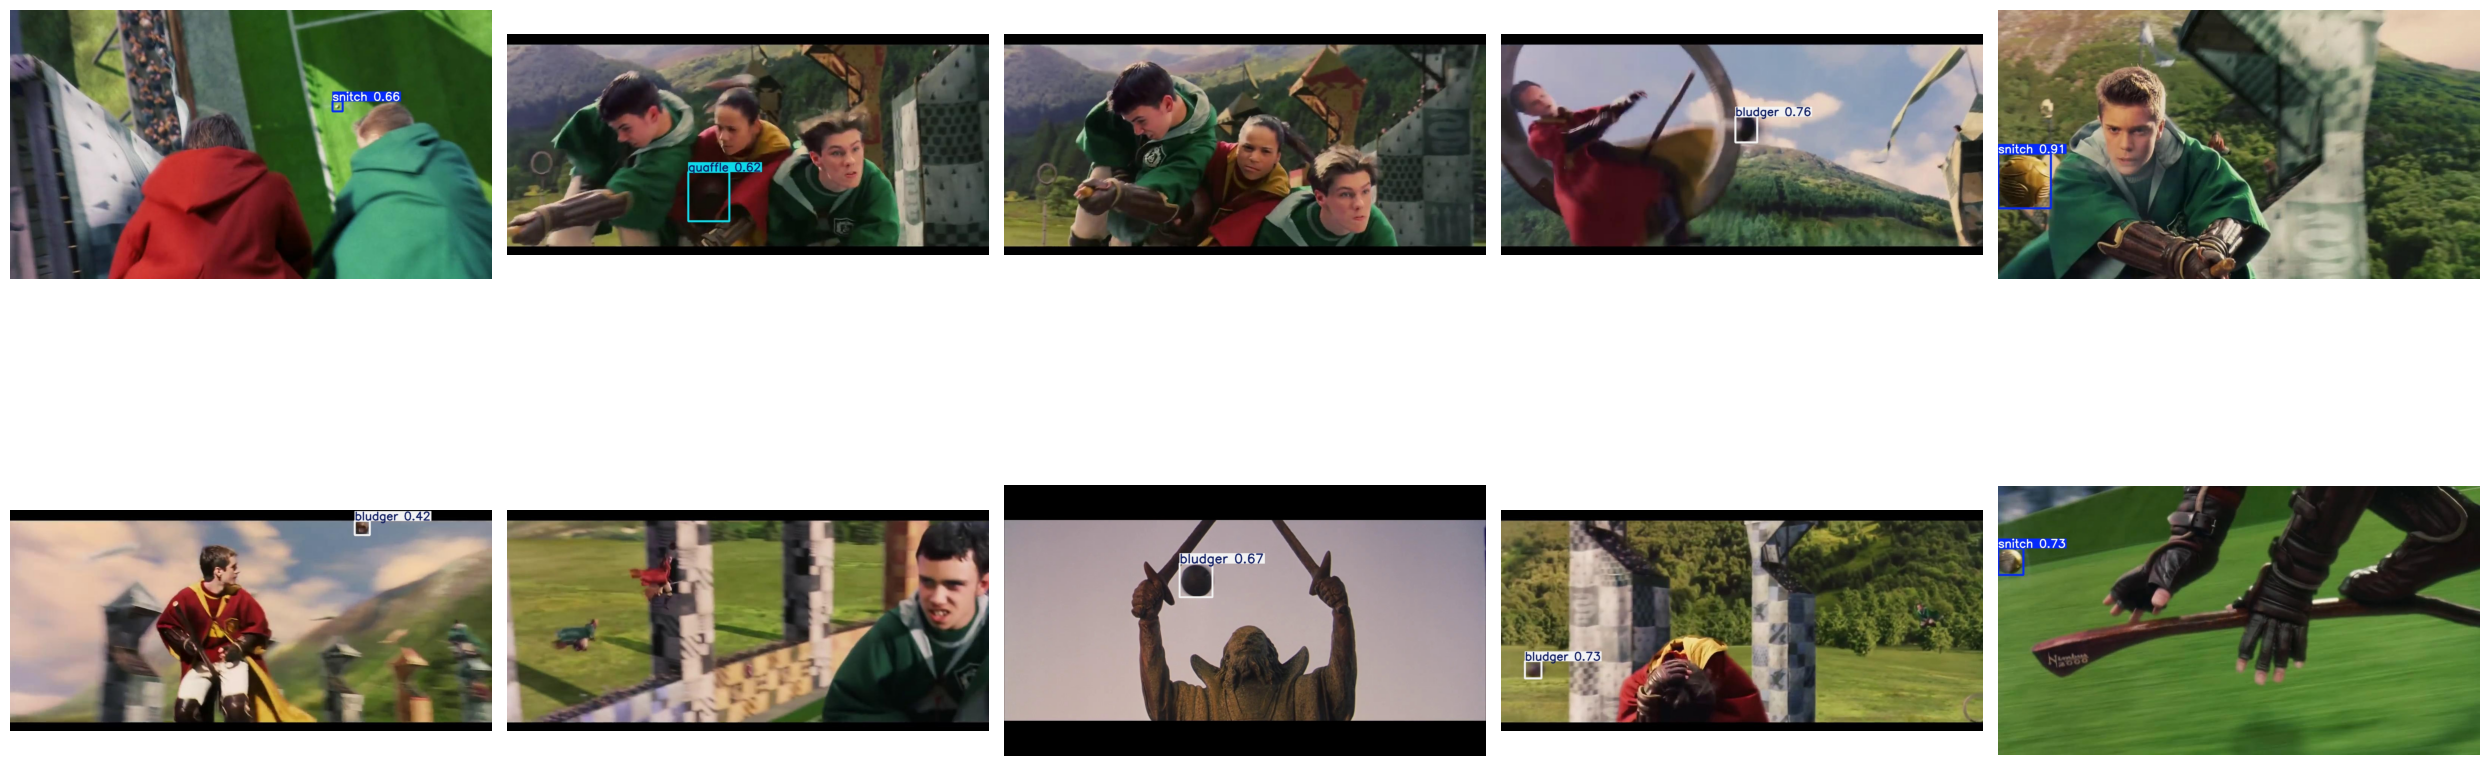

In [ ]:
result_dir = Path('runs/detect/train_weights83') # там сохранены предсказания
images = list(result_dir.glob('*.jpg'))[:10] # решила вывести 10 предсказаний

fig, axes = plt.subplots(2, 5, figsize=(25, 12))
for ax, img_path in zip(axes.flat, images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

Ваааау, моделька реально старается! Сначала я взяла 20 эпох, было слабовато. Потом довела до 50, и она стала хорошо распознавать снитч, но на картинках ни разу не было квофла.. на 100 эпохе суперски вышло!